In [3]:
import ROOT as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit


Welcome to JupyROOT 6.24/02


In [4]:
directory = '/Users/adit/Google Drive/Internship_ Research/Muon g-2/combined_forAdit_timealigned.root'
f = r.TFile(directory)
t = f.Get("LaserEvents/tree")

In [8]:
rdf = r.RDataFrame("LaserEvents/tree", directory)
df = pd.DataFrame(rdf.AsNumpy())


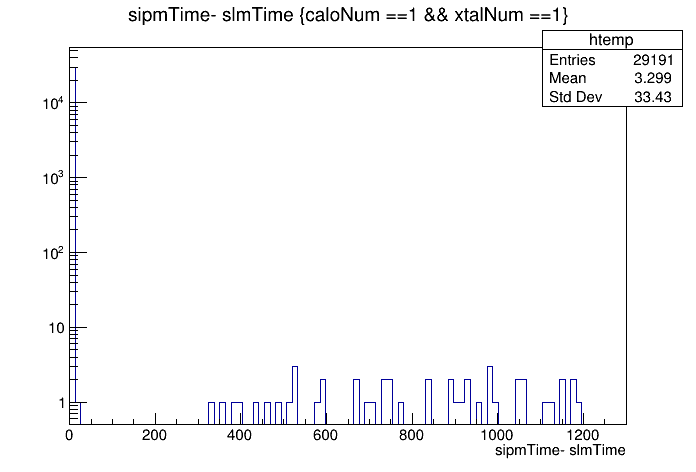

In [50]:
c =r.TCanvas()
t.Draw('sipmTime- slmTime', 'caloNum ==1 && xtalNum ==1')
c.SetLogy()
c.Draw()

#shows outliers after, say 50 clock ticks, of time difference

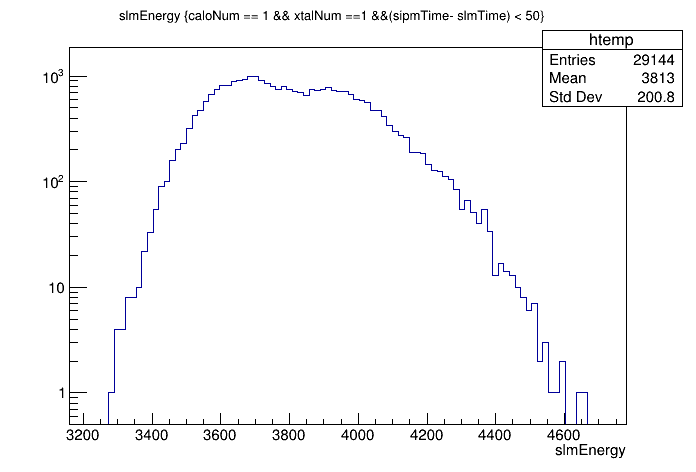

In [51]:
# plotting all the clean data
t.Draw('slmEnergy', 'caloNum == 1 && xtalNum ==1 &&(sipmTime- slmTime) < 50')
c.Draw()

#seem to be 2 outliers over 4600, can ignore ;


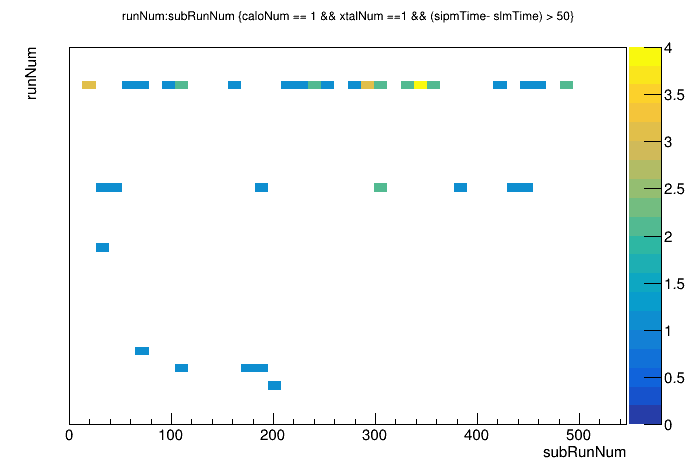

In [52]:
t.Draw('runNum:subRunNum', 'caloNum == 1 && xtalNum ==1 && (sipmTime- slmTime) > 50', 'colz')
c.Draw()

# no particular association with an run or subrun, just seems they're more frequent for later runs nothing significant
# no more cleaning required on the data, noise pulses do not have any common characterstics

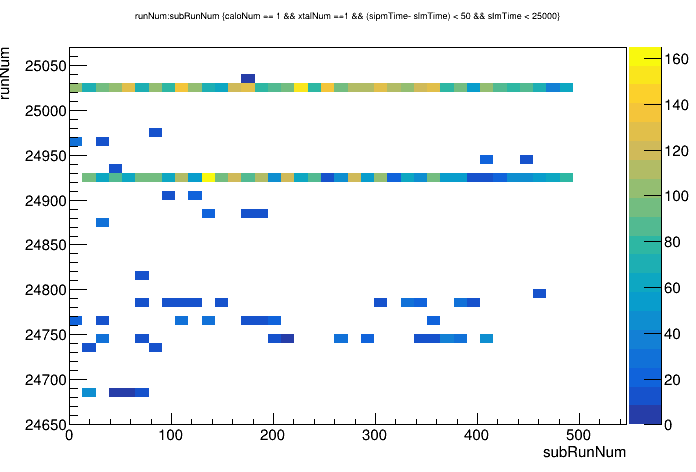

In [56]:
t.Draw('runNum:subRunNum', 'caloNum == 1 && xtalNum ==1 && (sipmTime- slmTime) < 50 && slmTime < 25000', 'colz')
c.Draw()

#some sort of weird behavior, initial runs seem to not have all subRunNums (idk if there is something to interpret)

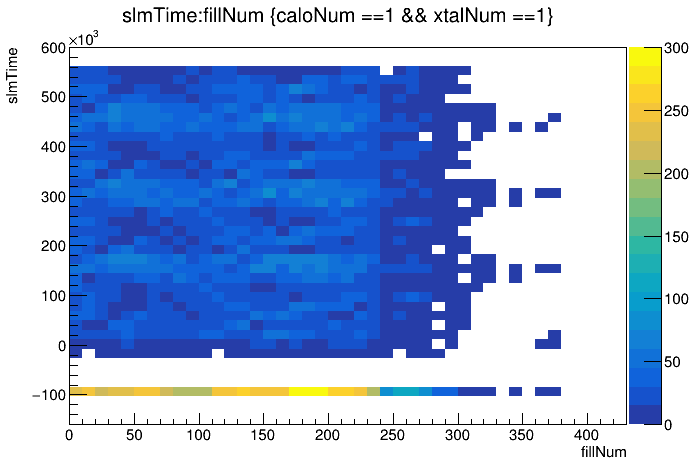

In [54]:
t.Draw('slmTime:fillNum', 'caloNum ==1 && xtalNum ==1', 'colz')
c.Draw()


#shows sync-fill pulse are at ~ -100k clock ticks and in-fill ones later than that
# also lesser data at higher fills (understandable?)

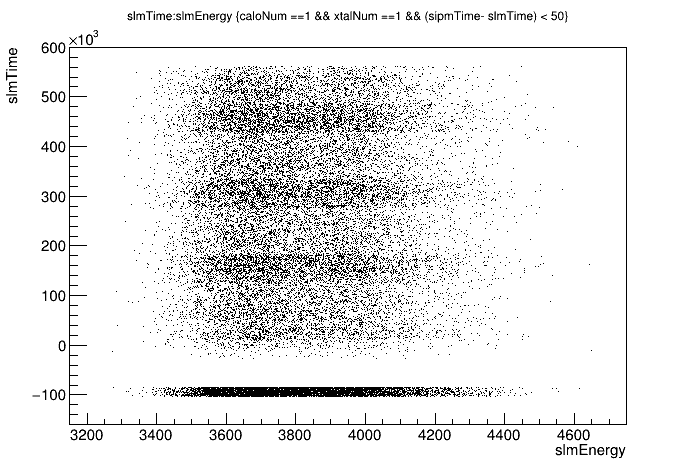

In [65]:
t.Draw('slmTime:slmEnergy', 'caloNum ==1 && xtalNum ==1 && (sipmTime- slmTime) < 50 && subRunNum = ', '.')
c.Draw()

In [83]:
df.nunique()

gpsTimeStamp        6353
cccTimeStamp        6353
runNum                18
subRunNum            340
fillNum              334
bunchNum              16
fillType               1
caloNum               24
xtalNum               54
sipmTime        36822917
sipmEnergy      37795515
sipmPedestal    37795510
sipmChi2        37795515
smPin1Amp           9125
smPin1Time          2095
smPin2Amp          10044
smPin2Time          2014
smPmtAmp               1
smPmtTime              1
lmPmtAmp1          52803
lmPmtAmp2          16427
lmPmtArea1         24840
lmPmtArea2          7065
lmPmtTime1         10103
lmPmtTime2         10524
slmTime           142930
slmEnergy         175150
slmPedestal       175150
slmChi2           175150
syncStatus             2
dtype: int64

In [26]:
allRunNums = [24928, 24939, 25026, 24760, 24747, 25027, 24796, 24783, 24881, 24903, 24732, 24948, 24963, 24685, 24976, 24873, 25032, 24818]
allSubRunNums = np.zeros(1)
for run in allRunNums:
    allSubRunNums = np.concatenate(pd.unique(df.loc[df['runNum']== run]['subRunNum']),allSubRunNums)

TypeError: only integer scalar arrays can be converted to a scalar index

In [84]:
calo = 1
xtal = 1
df_xtal = df.loc[df['caloNum']== calo].loc[df['xtalNum']==xtal]
df_filtered = df_xtal[df_xtal['sipmTime']-df_xtal['slmTime']< 50]
df_noise = df_xtal[df_xtal['sipmTime']-df_xtal['slmTime']> 50]

In [85]:
print(df_noise.nunique())
    
# only one bunch num not in data

gpsTimeStamp    47
cccTimeStamp    47
runNum           6
subRunNum       44
fillNum         41
bunchNum        15
fillType         1
caloNum          1
xtalNum          1
sipmTime        47
sipmEnergy      47
sipmPedestal    47
sipmChi2        47
smPin1Amp       47
smPin1Time      43
smPin2Amp       45
smPin2Time      45
smPmtAmp         1
smPmtTime        1
lmPmtAmp1       46
lmPmtAmp2       47
lmPmtArea1      46
lmPmtArea2      46
lmPmtTime1      47
lmPmtTime2      47
slmTime         47
slmEnergy       47
slmPedestal     47
slmChi2         47
syncStatus       0
dtype: int64


In [87]:
df_filtered['syncStatus'] = df_filtered['slmTime']<-25000
df_filtered['syncStatus']

/Users/adit/opt/anaconda3/envs/ROOT/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


1            True
55          False
109         False
163         False
5181         True
            ...  
37789042     True
37789096    False
37789150    False
37789204    False
37789258    False
Name: syncStatus, Length: 29144, dtype: bool

In [88]:

syncPulse = df_filtered[df_filtered['syncStatus']== True].rename(columns= {'slmEnergy':'syncEnergy'}) #[['subRunNum','fillNum', 'slmEnergy']]
avgEnergy = syncPulse.groupby('fillNum').mean().reset_index()[['fillNum', 'syncEnergy']]
df_filtered  = pd.merge(df_filtered,avgEnergy, how = 'inner', on = ['fillNum'])
df_filtered['energyRatio'] = df_filtered['sipmEnergy']/(df_filtered['slmEnergy']/df_filtered['syncEnergy'])

Warning in <TFile::Append>: Replacing existing TH1: h_2 (Potential memory leak).


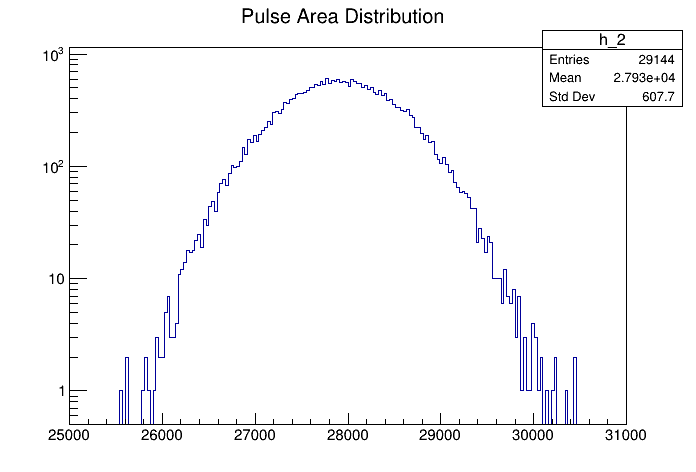

In [89]:
h2 = r.TH1D(f"h_{2}", "Pulse Area Distribution", 200, 25000, 31000)

for x in normalized_data['lmPmtArea1']:
    h2.Fill(x)

h2.Draw()
c.SetLogy()
c.Draw()

mean_area = h2.GetMean()
std_area = h2.GetStdDev()

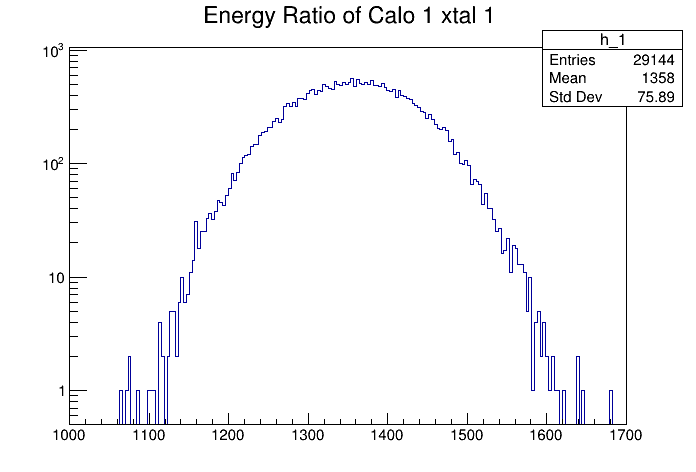

In [90]:
h = r.TH1D(f"h_{1}", "Energy Ratio of Calo 1 xtal 1", 200, 1000, 1700)

for x in normalized_data['energyRatio']:
    h.Fill(x)

h.Draw()
c.Draw()

mean = h.GetMean()

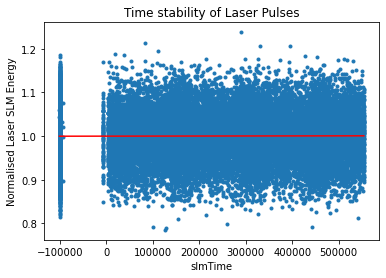

In [91]:
# graph ratio of SiPM energy & normalized SLM energy -vs- time (p.s. add labels and axes)
fig,ax = plt.subplots()
ax.plot(normalized_data['sipmTime'], normalized_data['energyRatio']/mean,".")
ax.set_title("Time stability of Laser Pulses")
ax.set_xlabel("slmTime")
ax.set_ylabel("Normalised Laser SLM Energy")
# fit a curve (linear for now) through the stability of time 


def func(x,m,b):
    return m*x + b 

initial_guess = [1.2, 0.03]
pars, pcov = curve_fit(func, normalized_data['sipmTime'], normalized_data['energyRatio']/mean, p0=initial_guess)
xfit = np.linspace(np.amin(normalized_data['sipmTime']),np.amax(normalized_data['sipmTime']))
yfit = func(xfit, pars[0], pars[1])
plt.plot(xfit,yfit,'r-',label=f"Linear Fit\nm={pars[0]:.2f}\nb={pars[1]:.2f}")

slope = pars[0]
std = np.sqrt
